In [1]:
import torch
import torch.nn as nn

import math
import pickle
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

DEVICE = 'cuda:1'

In [2]:
%matplotlib notebook

# Overview

This notebook contains 4 types of animations of the minimization of the sc/ce losss directly on the last layer representations in 2D/3D
- supervised contrastive loss minimization
- cross entropy loss minimization
- supervised contrastive loss gradients (depending on temeprature)
- comparison sc/ce side-by-side

# Visualize SupCon Loss Optimization

In [3]:
class SupConLoss(nn.Module):

    def __init__(self,
                 temperature):

        self.temperature = temperature

    def __call__(self, y_hat, y, reduce=True):
        
        self.inv_eye = ~torch.eye(
            y.shape[0], dtype=bool, device = y.device)

        # latent representation
        z = y_hat

        z = z/torch.norm(z, p=2, keepdim=True, dim=1)


        y = y.view(-1, 1)

        # mask(i,j) = true if label_i == label_j
        mask = torch.eq(y, y.T)

        # weighting factor
        w = 1./(mask.sum(-1, keepdim=True).float()-1)
        w[w==float('Inf')] = 0
        # inner product matrix (scaled by temp)
        ips = torch.div(torch.matmul(z, z.T), self.temperature)
        
        # new inner product matrix where diagonal is removed
        ips = ips.masked_select(self.inv_eye).view(z.size(0), z.size(0) - 1)

        # new mask where diagonal is removed
        mask = mask.masked_select(self.inv_eye).view(z.size(0), z.size(0) - 1)

        # apply log-softmax along dim=1 to inner product matrix with removed diagonal entries
        ips = nn.functional.log_softmax(ips, dim=1)*w
 
        return -ips.masked_select(mask).sum() / float(y.size(0))

In [4]:
def gen_rand_data(shape, num_classes, num_samples):
    
    valid_shapes = ['circle', 'sphere', 'highdim']
    if shape not in valid_shapes:
        raise Exception(shape + ' is not a shape in ' + str(valid_shapes))
        
    labels = torch.randint(num_classes,(num_samples,))
    
    if shape == 'circle':
        phi = torch.rand(num_samples)* 2*math.pi
        x = torch.cos(phi)
        y = torch.sin(phi)
        points = torch.stack([x,y]).T
        points.requires_grad=True
    
    if shape == 'sphere':
        theta = torch.rand(num_samples)
        theta = torch.acos(2*theta-1)
        phi = torch.rand(num_samples)* 2*math.pi

        x = torch.sin(theta) * torch.cos(phi)
        y = torch.sin(theta) * torch.sin(phi)
        z = torch.cos(theta)
        points = torch.stack([x,y,z]).T
        points.requires_grad=True
        
    if shape == 'highdim':
        
        points = torch.randn(num_samples,512)
        points = points/torch.norm(points, p=2, dim=1, keepdim=True)
        points.requires_grad = True
        
    return points, labels

In [5]:
from torch.utils.data import Dataset, DataLoader

    
class SphereDataset(Dataset):
    def __init__(self, num_classes, num_samples, dim = 2, points=None, labels=None):
        
        if torch.is_tensor(points) and points.shape[0] == labels.shape[0]:
            self.points = points.detach()
            self.points.requires_grad = True
            self.labels = labels
            self.num_classes = len(np.unique(self.labels))
            self.num_samples = self.points.size(0)
            
        else:
            self.num_classes = num_classes
            self.num_samples = num_samples
            self.gen_rand_data(dim)

    def __len__(self):
        return self.points.size(0)

    def __getitem__(self, idx):
        return self.points[idx], self.labels[idx]
    
    def gen_rand_data(self, dim):  
        
        self.labels = np.random.randint(0,self.num_classes,(self.num_samples,))
        
        self.points = torch.randn(self.num_samples,dim + 1)
        self.points = self.points/torch.norm(self.points, p=2, dim=1, keepdim=True)
        self.points.requires_grad = True 
        
    
    def copy(self):
        p = torch.tensor(self.points.detach().numpy(), requires_grad=True)
        return SphereDataset(0,0,0,p, self.labels)
        


In [6]:
class configuration():
    def __init__(self,  loss_fn, parameter, lr, single = True):
        
        self.loss_fn = loss_fn, 
        self.param = parameter
        self.lr = lr
        self.single = single

In [7]:
def minimizer_step(dl_train, bs, lr = 5, temp=0.07, bd_cond=True, loss_fn=None, ):
    
    criterion = loss_fn(temp)
    opt = torch.optim.SGD([dl_train.dataset.points], lr=lr, momentum=.9)
    

    losses = []
    for batch_i, (batch_x, batch_y) in enumerate(dl_train):
        
        opt.zero_grad()        
        batch_x = batch_x.to(DEVICE)
        batch_y = batch_y.to(DEVICE)        
        
        loss = criterion(batch_x, batch_y)
        
        loss.backward() 
        losses.append(loss.item())


        opt.step() 
        with torch.no_grad():
            dl_train.dataset.points = dl_train.dataset.points/torch.norm(dl_train.dataset.points,dim=1, p=2, keepdim=True)
            dl_train.dataset.points.requires_grad = True
    return losses

In [8]:
class VisualizeOptimization:
    
    def __init__(self, dataset, config):
        self.data = dataset
        self.config = config
        self.losses = []
        self.len = len(dataset)
        self.n = 0
        self.color_list = [
        (0.92,0.26,0.21),
        (0.20,0.66,0.33),
        (0.26,0.52,0.96),
        (244./255, 180./255, 0),
        "magenta",
        "yellow",
        "#e67e22",
        "#5d6d7e",
        "#82e0aa",
        "#85c1e9"
        ]
        self.colors = [self.color_list[i.item()] for i in self.data.labels]
        
    def setup_plot(self, setup_ax=True, dim3=False):         
        self.fig = plt.figure(figsize=(5,6))        
        self.spec = gridspec.GridSpec(ncols=1, nrows=2, figure=self.fig, height_ratios= [5, 1])
        self.dim3 = dim3
        
        if self.dim3 == True:
            projection = "3d"
        else:
            projection = None
        self.ax1 = self.fig.add_subplot(self.spec[0,0], projection=projection)
        self.ax2 = self.fig.add_subplot(self.spec[1,0])

        if setup_ax:
            self.setup_axs()
        
    def setup_axs(self):
        p = self.data.points
        self.ax1.collections.clear()
        self.ax2.collections.clear()

        self.ax1.set_axis_off()
        self.ax1.set_xlim([-2,2])
        self.ax1.set_ylim([-2,2])
        
        if self.dim3:
            self.ax1.set_zlim([-2,2])
            self.ax1.dist = 4   
            
            self.scat = self.ax1.scatter(p[:,0].tolist(), p[:,1].tolist(),p[:,2].tolist(),
                                    c=self.colors, s=1) 
            # draw sphere
            u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:20j]
            x = np.cos(u)*np.sin(v)
            y = np.sin(u)*np.sin(v)
            z = np.cos(v)
            self.ax1.plot_wireframe(x, y, z, color="k", alpha=0.2)
                       
        else:
            self.scat = self.ax1.scatter(p[:,0].tolist(), p[:,1].tolist(),
                                    c=self.colors, s=15)
            # draw circle
            circ = plt.Circle((0, 0), radius=1, color='k', fill=False, )
            self.ax1.add_patch(circ)
            self.ax1.set_aspect("equal")
            
            
        self.scat2 = self.ax2.scatter([],[])
        self.n_losses = 100
        self.ax2.set_xlim([0,self.n_losses])
    
    def steps(self, n):
        for i in range(n):
            self.step()
            if n == 200:
                self.config.lr
            
    def step(self, num=0):
        
        
        #update dataset
        dl = torch.utils.data.DataLoader(self.data, batch_size=self.len)

        l = minimizer_step(dl, self.len,lr = self.config.lr,
                         temp=self.config.param, 
                         bd_cond = True, 
                         loss_fn=self.config.loss_fn[0]);
        self.losses.append(l[0])
        
        

        #draw
        p = self.data.points.detach()
        if self.dim3:
            self.scat._offsets3d = (p[:,0].tolist(), p[:,1].tolist(),p[:,2].tolist())
        else:
            self.scat.set_offsets(p[:,0:2])
       
        # plot losses        
        losses_graph = np.asarray( (range(len(self.losses)), self.losses)).transpose()
        l_min = np.asarray(self.losses).min()
        l_max = np.asarray(self.losses).max()
        self.ax2.set_ylim([l_min*(1-0.1*np.sign(l_min)), l_max*(1+0.1*np.sign(l_max))])
        #self.ax2.set_xlim([max(0,self.n-self.n_losses-2), max(self.n_losses, self.n+5)])
        self.ax2.set_xlim(0-len(self.losses)*.05, len(self.losses)*1.05)
        losses_to_plot = losses_graph#[-self.n_losses:]
        self.scat2.set_offsets( losses_to_plot )
        self.scat2.set_color(["b"]*(len(losses_to_plot)-1)+["r"])
        self.scat2.set_sizes([2]*(len(losses_to_plot)-1)+[10])
            
        title = 'timestep {0:3}, loss = {1:5.2f}'.format(self.n,self.losses[self.n])
        self.ax1.set_title(title)
        
#         if num==500:
#                 for x in p[0:4]:
#                     for y in p[0:4]:
#                         self.ax1.plot( [x[0],y[0]],[x[1],y[1]],[x[2],y[2]], color='black')
        
        self.n += 1
        
    def animate(self, frames = -1, interval=25, dim3=False):
        
        if frames == -1:
            frames = 1
            repeat = True
        else:
            repeat = False
        self.setup_plot(dim3=dim3) 
        self.dim3 = dim3
        self.ani = FuncAnimation(self.fig, self.step, frames = frames, 
                                 interval=interval, init_func = self.setup_axs, blit=True, repeat = repeat)
        

In [9]:
configs = [
    configuration(loss_fn=SupConLoss, parameter= 1, lr=100), #parameter is the temperature param t of supcon
    configuration(loss_fn=SupConLoss, parameter= .1, lr=1), #higher t requires highe rlearning rate
    configuration(loss_fn=SupConLoss, parameter= .3, lr=10)
]

REMARK: Empirically, the intra-class distances diminish collaps fast. Depending on the temperature parameter, the inter-class separations might grow only slowly. t=0.3 is a good value to achieve maximal separation in reasonable time. Alternatively, one could use a lr scheduler with eventually increasing learning rate to speed up convergence.

<IPython.core.display.Javascript object>


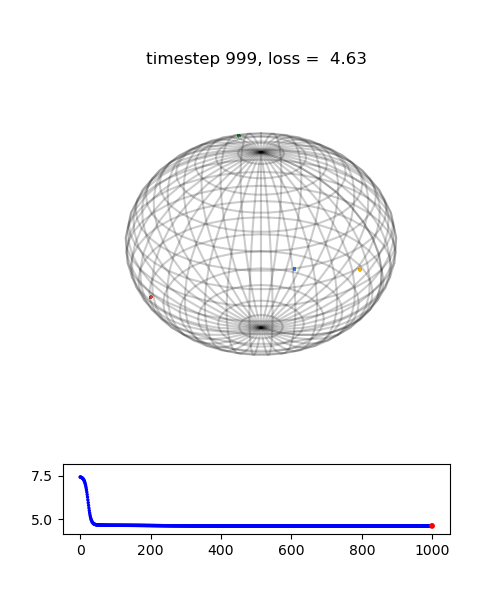

In [10]:
dim3 = True # true generates 3D plot on sphere instead of 2D plot on circle
n_samples = 100 #samples per class
if dim3: 
    n_classes = 4
    data = SphereDataset(4,n_samples*n_classes,2) 
    
else:
    n_classes = 3
    data = SphereDataset(4,n_samples*n_classes,1)     
data.labels = np.asarray([i for i in range(n_classes)]*n_samples) # make each label occur equally often

a = VisualizeOptimization(data, configs[2])
ani = a.animate(frames= 1000, interval = 1000/24, dim3=dim3)

<IPython.core.display.Javascript object>


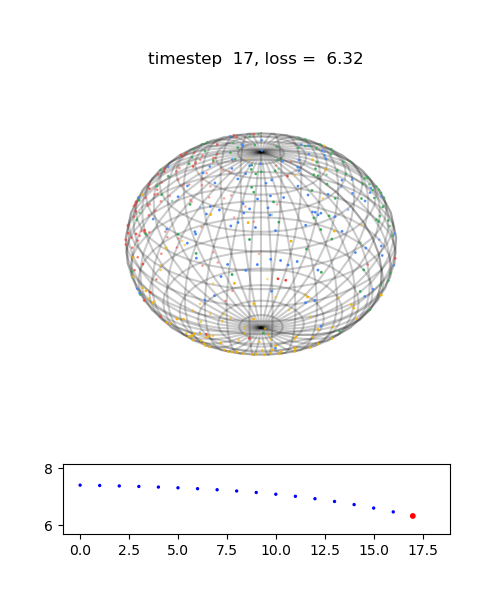

In [146]:
# alternatively, set frames to 0 and step through animation manually
dim3 = True # true generates 3D plot on sphere instead of 2D plot on circle
n_samples = 100 #samples per class
if dim3: 
    n_classes = 4
    data = SphereDataset(4,n_samples*n_classes,2) 
    
else:
    n_classes = 3
    data = SphereDataset(4,n_samples*n_classes,1)     
data.labels = np.asarray([i for i in range(n_classes)]*n_samples) # make each label occur equally often

a = VisualizeOptimization(data, configs[2])
ani = a.animate(frames= 0, interval = 1000/24, dim3=dim3)


In [164]:
a.step()

In [15]:
# compute inner products between points.
# at minimal loss, the inner products are -1/(n_classes-1)
torch.matmul(a.data.points,a.data.points.T)

tensor([[ 1.0000, -0.3333, -0.3333,  ..., -0.3333, -0.3333, -0.3333],
        [-0.3333,  1.0000, -0.3333,  ...,  1.0000, -0.3333, -0.3333],
        [-0.3333, -0.3333,  1.0000,  ..., -0.3333,  1.0000, -0.3333],
        ...,
        [-0.3333,  1.0000, -0.3333,  ...,  1.0000, -0.3333, -0.3333],
        [-0.3333, -0.3333,  1.0000,  ..., -0.3333,  1.0000, -0.3333],
        [-0.3333, -0.3333, -0.3333,  ..., -0.3333, -0.3333,  1.0000]],
       grad_fn=<MmBackward0>)

# Visualize Cross Entropy Loss Optimization

In [165]:
def simulate_ce(dl_train, W, bs, lr = 5, temp=0.07, bd_cond=True, wd = 0.0, bn=True, sphere=False):
    
    
    #criterion = loss_fn(bs, {'+': 5, '-': 5}, temp)
    criterion = torch.nn.CrossEntropyLoss()
    opt = torch.optim.SGD([dl_train.dataset.points, W], lr=lr, momentum=.9, weight_decay=wd)
    #opt = torch.optim.Adam([dl_train.dataset.points, W], lr=lr)
    W = W.to(DEVICE)
    W.retain_grad()
    losses = []
    
    
    
    for batch_i, (batch_x, batch_y) in enumerate(dl_train):
        
        opt.zero_grad()  
        
        batch_x = batch_x.to(DEVICE)        
        batch_x = torch.matmul(W,batch_x.T).T
        batch_y = batch_y.to(DEVICE)        
        
        loss = criterion(batch_x, batch_y)# + wd * (W**2).sum()/2
        
        loss.backward() 
        losses.append(loss.item())

        opt.step()
        if bn==True:
            with torch.no_grad():
                dl_train.dataset.points = (dl_train.dataset.points - dl_train.dataset.points.mean(dim=0,keepdim=True))/(dl_train.dataset.points.std(dim=0,keepdim=True))
                dl_train.dataset.points.requires_grad=True
        if sphere == True:
            #project onto sphere
            with torch.no_grad():
                dl_train.dataset.points = dl_train.dataset.points/torch.norm(dl_train.dataset.points,dim=1, p=2, keepdim=True).max()
                dl_train.dataset.points.requires_grad = True
    return losses

In [166]:
def train_toy_example(n_samples,n_classes,epochs, lr, wd, bn, sphere):
    
    b = SphereDataset(n_classes,n_samples*n_classes)
    b.labels = np.asarray([i for i in range(n_classes)]*n_samples)
    with torch.no_grad():
        b.points= b.points*torch.rand([len(b.points),1])
    b.points.requires_grad=True
    
    cd = b
    W = torch.randn(n_classes,b.points.shape[1],requires_grad=True)
    dl = torch.utils.data.DataLoader(b, batch_size=len(b), shuffle=True)
    
    ps=[]
    ws = []
    losses = []
    als = []

    for i in range(epochs):
        l = simulate_ce(dl, W, len(b),lr =lr,
                                 temp=1, 
                                 bd_cond = True, 
                                 wd=wd, bn=bn, sphere=sphere);
        losses.append(l[0])
        ps.append(b.points.clone().detach())
        ws.append(W.clone().detach())
        p = ps[-1]#/torch.norm(ps[-1],p=2,dim=1,keepdim=True)
        p = p.view(n_samples,n_classes,b.points.shape[1])

        al = torch.matmul(p,(ws[-1]/torch.norm(ws[-1],p=2,dim=1,keepdim=True)).T).diagonal(dim1=1,dim2=2)
        al = ((al**2).sum(dim=0,keepdim=True)/al.shape[0]).sqrt()
        als.append(al.squeeze().numpy())
    
    return (losses, ps, ws,als)

In [167]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

#Plotting 3D arrows, see https://stackoverflow.com/a/22867877
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)
        
class plot_sphere_weights:
    
    def __init__(self,
                points_list,
                weights_list,
                labels, 
                losses,
                trajectory = False,
                show_losses = True,
                interval = 200, 
                save = None, file_format="mp4"):
        self.ps = points_list
        self.ws = weights_list
        self.labels = labels
        self.interval = interval
        self.trajectory = trajectory
        self.len_traj = 5
        self.losses = losses
        self.show_losses = show_losses
        self.color_list = [
        (0.92,0.26,0.21),
        (0.20,0.66,0.33),
        (0.26,0.52,0.96),
        (244./255, 180./255, 0),
        "magenta",
        "yellow",
        "#e67e22",
        "#5d6d7e",
        "#82e0aa",
        "#85c1e9"
        ]
        self.colors = [self.color_list[i.item()] for i in labels]
        
        
        if show_losses:
            self.fig = plt.figure(figsize=(5,6))
            gs = self.fig.add_gridspec(2,1, height_ratios = (5,1))
            self.ax = self.fig.add_subplot(gs[0,0], projection = "3d")
            self.ax1 = self.fig.add_subplot(gs[1,0])

        else:
            self.fig = plt.figure(figsize=(5,5))
            self.ax = self.fig.add_subplot( projection = "3d")  
        

        self.ani = FuncAnimation(self.fig, self.update, frames = len(points_list), 
                                 interval=self.interval, init_func = self.setup_plot, blit=True, repeat=False)
        
        if save:
            if file_format == "gif":
                self.ani.save(save+"."+file_format, dpi=80, fps = 1000/self.interval, writer='imagemagick')
            else:
                self.ani.save(save+"."+file_format, dpi=80, fps = 1000/self.interval)
            
            
    
    def setup_plot(self):
        #self.fig.suptitle("Minimizing the Cross Entropy Loss")
        self.ax.collections.clear()
        
        self.ax.set_xlim([-2,2])
        self.ax.set_ylim([-2,2])
        self.ax.set_zlim([-2,2])
        self.ax.dist = 4
        self.ax.set_axis_off()
       
        # draw sphere
        u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:20j]
        x = np.cos(u)*np.sin(v)
        y = np.sin(u)*np.sin(v)
        z = np.cos(v)
        self.ax.plot_wireframe(x, y, z, color="k", alpha=0.2)
        self.scat = self.ax.scatter(self.ps[0][:,0].tolist(), self.ps[0][:,1].tolist(),self.ps[0][:,2].tolist(),
                                    c=self.colors, s=1)
        
        # plot losses
        if self.show_losses:
            self.ax1.collections.clear()
            self.scat1 = self.ax1.scatter(range(len(self.losses)), self.losses, s = 2, c="b")
            self.ax1.dist = 4

        return self.scat,
    
    def update(self,n):
        p = self.ps[n]
        w = self.ws[n]
        for artist in self.ax.artists:
            artist.remove()
        if self.trajectory == True:
            self.ax.collections[-1].set_sizes([3]*p.shape[0])
            self.ax.scatter(p[:,0].tolist(), p[:,1].tolist(), p[:,2].tolist(), c=self.colors, s=5)
            if len(self.ax.collections)>self.len_traj:
                self.ax.collections[1].remove()
        else:
            self.scat._offsets3d = (p[:,0].tolist(), p[:,1].tolist(),p[:,2].tolist())
        
        for l in range(len(w)):
            w_l = w[l]
            arrow = Arrow3D((0,w_l[0]), (0,w_l[1]), 
                        (0,w_l[2]), mutation_scale=5, 
                        lw=1.5,  arrowstyle="-|>", color=self.color_list[l])
            self.ax.add_artist(arrow)
        if n==5000-1:
            for x in p[0:4]:
                for y in p[0:4]:
                    self.ax.plot( [x[0],y[0]],[x[1],y[1]],[x[2],y[2]], color='black')
        
        title = 'timestep {0:3}, loss = {1:5.2f}'.format(n,losses[n])
        self.ax.set_title(title)

    
#         if self.show_losses:
#             self.scat1.set_color(kr(n, "b", "r", len(self.losses)))
#             self.scat1.set_sizes(kr(n, 2, 10, len(self.losses)))

In [168]:
lr = 10
wd = 0.01 

epochs=1000
n_samples=100
bn = False
sphere = True # controls wether representations are projected onto sphere. If not, they still converge towards equal norm 
n_classes = 4


losses, ps, ws, als = train_toy_example(n_samples, n_classes, epochs, lr, wd, bn=bn, sphere=sphere)

norms = [(w**2).sum(1).sqrt().numpy() for w in ws]

prods = []
for w in ws:
    w = w/ (w**2).sum(1, keepdim=True).sqrt()
    prod = torch.matmul(w,w.T)
    prod = prod[prod.triu(1).bool()]
    prods.append(prod.numpy())


<IPython.core.display.Javascript object>


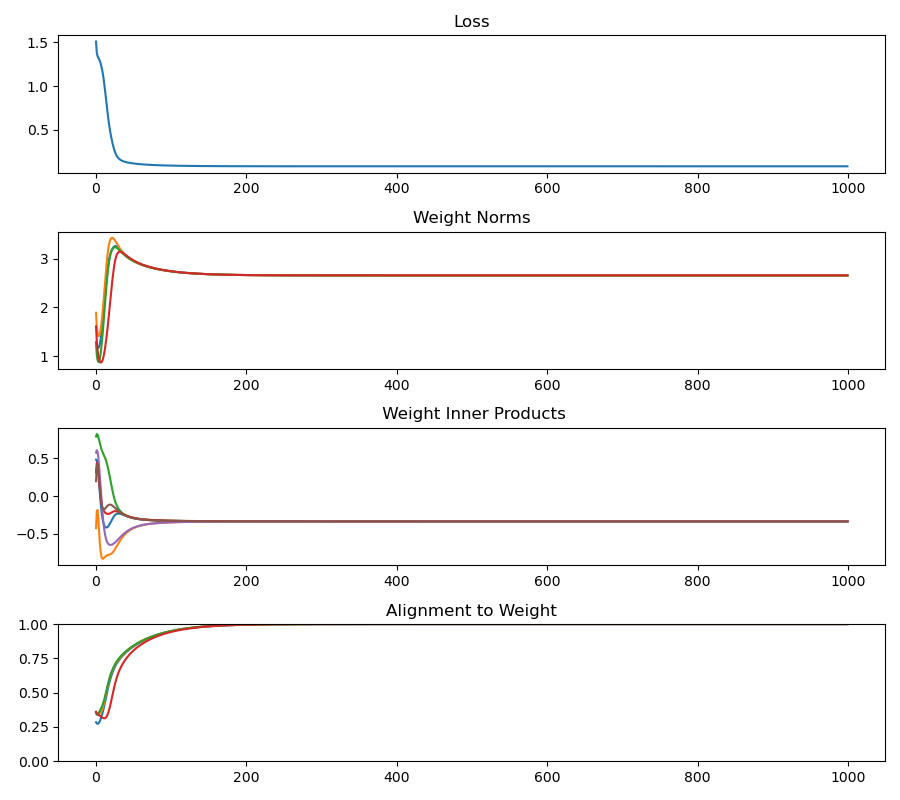

In [170]:
fig, ax = plt.subplots(4, figsize=(9,8))
titles=["Loss","Weight Norms", " Weight Inner Products", "Alignment to Weight"]
ax[0].plot(losses)
ax[0].set_title
ax[1].plot(norms)
ax[2].plot(prods)
ax[3].plot(als)
ax[3].set_ylim((0,1))
for i in range(4):
    ax[i].set_title(titles[i])
fig.tight_layout()

In [171]:
#inner prods between weight vectors:
prod

tensor([-0.3333, -0.3333, -0.3333, -0.3333, -0.3333, -0.3333])

<IPython.core.display.Javascript object>


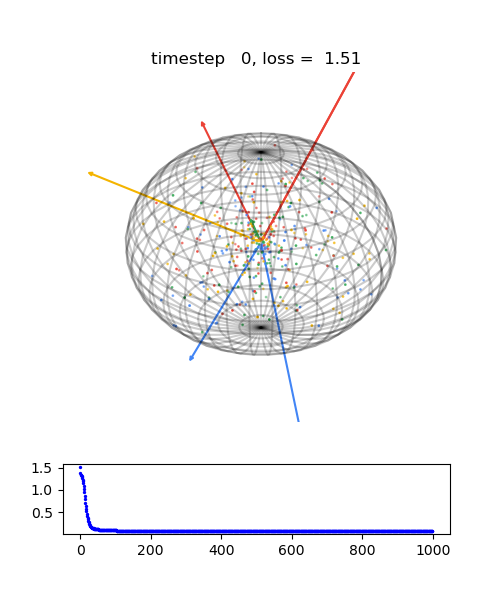

In [172]:
labels = np.asarray([i for i in range(n_classes)]*n_samples)
anim2 = plot_sphere_weights(ps, ws, labels, losses, interval = 2.5,  trajectory = False, show_losses = True, save=None, file_format="mp4")

In [173]:
# jump to a time step
#step = epochs-1
#step = 10
step=0
anim2.update(step)

# Compare Gradients of SC for different temperatures

In [174]:
class CompareGradients:
    
    def __init__(self, dataset, configs, bs = None):

        self.data = []
        for i in range(len(configs)):
            dat = dataset.copy()
            self.data.append(dat)
        self.configs = configs
        self.len = len(dataset)
        self.color_list = [
        (0.92,0.26,0.21),
        (0.20,0.66,0.33),
        (0.26,0.52,0.96),
        (244./255, 180./255, 0),
        "magenta",
        "yellow",
        "#e67e22",
        "#5d6d7e",
        "#82e0aa",
        "#85c1e9"
        ]
        
        
        
        
    def setup_plot(self):  
        
        self.fig = plt.figure(figsize=(5,5))
        self.ax = self.fig.add_subplot( projection = "3d")

        self.setup_axs()
        
    def setup_axs(self):
        p = self.data[0].points
        self.ax.collections.clear()

        self.ax.set_xlim([-1,1])
        self.ax.set_ylim([-1,1])
        self.ax.set_zlim([-1,1])
        self.ax.dist = 6
        self.ax.set_axis_off()

        # draw sphere
        u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
        x = np.cos(u)*np.sin(v)
        y = np.sin(u)*np.sin(v)
        z = np.cos(v)
        self.ax.plot_wireframe(x, y, z, color="k", alpha=0.2)
        self.scat = self.ax.scatter(p[:,0].tolist(), p[:,1].tolist(),p[:,2].tolist(),
                                    c='b', s=5)
        
        
    def step(self, num=0):        
        #num has no function but is required for the animation
        
        for i in range(len(self.configs)):
                config_i = self.configs[i]
                old_p = torch.tensor(np.asarray(self.data[i].points.detach()))

                #update dataset
                dl = torch.utils.data.DataLoader(self.data[i], batch_size=self.len)
                if config_i.param != 'no_training':
                    l = minimizer_step(dl, self.len,lr = config_i.lr,
                                     temp=config_i.param, 
                                     bd_cond = True, 
                                     loss_fn=config_i.loss_fn[0]);


                #draw
                for n in range(self.len):
                    p_n = self.data[i].points.detach()[n]
                    old_p_n = old_p[n]
                    diff = [ [old_p_n[j].item(), p_n[j].item()] for j in range(3)]
                    a = Arrow3D(diff[0], diff[1], 
                        diff[2], mutation_scale=5, 
                        lw=1,  arrowstyle="-|>", color=self.color_list[i])
                    self.ax.add_artist(a)
                    
    def steps(self, n):
        for i in range(n):
            self.step()
        
        
    def animate(self, frames = 5, interval=1000):
        self.fig = plt.figure(figsize=(5,5))
        self.ax = self.fig.add_subplot( projection = "3d")
        self.ax.collections.clear()

        
        self.ani = FuncAnimation(self.fig, self.step, frames = frames, 
                                 interval=interval, init_func = self.setup_axs, blit=True, repeat=False)

        
    
        return self.ani

In [175]:
configs = [    
    configuration(loss_fn=SupConLoss, parameter= .03, lr=0.03),
    configuration(loss_fn=SupConLoss, parameter=  .1, lr=0.1),
    configuration(loss_fn=SupConLoss, parameter=  .3, lr=.3),
    configuration(loss_fn=SupConLoss, parameter=   1, lr=1)
]

<IPython.core.display.Javascript object>


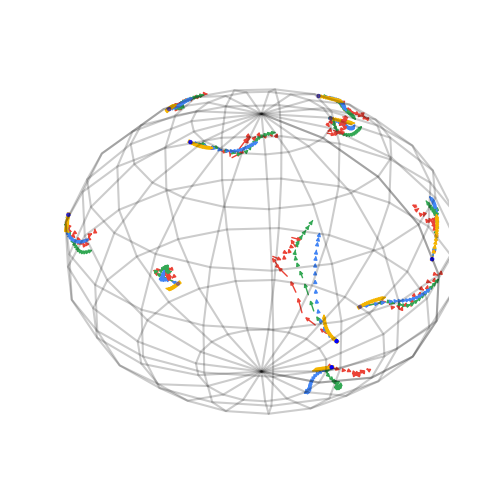

In [176]:
# Plot updates for different hyperparameter settings (=config) starting from the same initial position
data = SphereDataset(1,10)
C = CompareGradients(data, configs )
C.animate(frames=15)

# Compare SC and CE side-by-side

In [177]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

        
class compare_ce_sc:
    
    def __init__(self,
                ce_points_list,
                ce_weights_list,
                sc_points_list,
                labels,
                interval = 50):
        self.len = len(ce_points_list)
        self.ps_ce = ce_points_list
        self.ws_ce = ce_weights_list
        self.ps_sc = sc_points_list
        self.ps = [self.ps_ce, self.ps_sc]
        self.labels = labels
        self.interval = interval
        self.color_list = [
        (0.92,0.26,0.21),
        (0.20,0.66,0.33),
        (0.26,0.52,0.96),
        (244./255, 180./255, 0),
        "magenta",
        "yellow",
        "#e67e22",
        "#5d6d7e",
        "#82e0aa",
        "#85c1e9"
        ]
        self.colors = [self.color_list[i.item()] for i in labels]
        

        
        self.fig = plt.figure(figsize=(8,4))
        self.ax_ce = self.fig.add_subplot(1,2,1, projection = "3d")  
        self.ax_sc = self.fig.add_subplot(1,2,2, projection = "3d")
        
        self.axes = [self.ax_ce,self.ax_sc]
        
        self.scats = []
        

        self.ani = FuncAnimation(self.fig, self.update, frames = self.len + 1, 
                                 interval=self.interval, init_func = self.setup_plot,
                                 blit=True, repeat=False)
        
        
        #self.ani.save("comparison_100_1.gif", dpi=300, fps = 1000/self.interval, bitrate=900)
        #self.ani.save("comparison_100_1.mp4", dpi=300, fps = 1000/self.interval, bitrate=900)
        
    def setup_plot(self):  
        
        for ax, ps_x in zip(self.axes, self.ps):
            ax.collections.clear()
            ax.set_xlim([-1,1])
            ax.set_ylim([-1,1])
            ax.set_zlim([-1,1])
            ax.dist = 10
            ax.set_axis_off()
       
            # draw sphere
            u, v = np.mgrid[0:2*np.pi:60j, 0:np.pi:30j]
            x = np.cos(u)*np.sin(v)
            y = np.sin(u)*np.sin(v)
            z = np.cos(v)
            ax.plot_wireframe(x, y, z, color="k", alpha=0.2)
            
            self.scats.append(ax.scatter(ps_x[0][:,0].tolist(), 
                                         ps_x[0][:,1].tolist(),
                                         ps_x[0][:,2].tolist(),
                                         c=self.colors, s=15) )
        self.axes[0].set_title('Cross Entropy')
        self.axes[1].set_title('Supervised Contrastive')
        self.fig.tight_layout()

        #return self.scats,
    
    def update(self,n):
        
        if n < self.len-1:
        
            for ax, ps_x, scat in zip(self.axes,self.ps,self.scats):

                for _ in range(len(ax.artists)):
                    ax.artists[0].remove()

                p = ps_x[n]            

                scat._offsets3d = (p[:,0].tolist(), p[:,1].tolist(),p[:,2].tolist())

            # the following assumes that ce is drawn in axes[0]
            w = self.ws_ce[n]
            for l in range(len(w)):
                w_l = w[l]
                arrow = Arrow3D((0,w_l[0]), (0,w_l[1]), 
                            (0,w_l[2]), mutation_scale=5, 
                            lw=1.5,  arrowstyle="-|>", color=self.color_list[l])
                self.axes[0].add_artist(arrow)

            #self.fig.suptitle('timestep {0:3}'.format(n))
        
        else:
            for ax, ps_x, scat in zip(self.axes,self.ps,self.scats):
                p = ps_x[-1]
                for x in p[0:4]:
                    for y in p[0:4]:
                        ax.plot( [x[0],y[0]],[x[1],y[1]],[x[2],y[2]], color='black')
        self.fig.tight_layout()

In [178]:
def train_toy_example(n_samples,n_classes, epochs, lr, wd=0.1, temp=1):
    
    data = SphereDataset(n_classes,n_samples*n_classes)
    data.labels = np.asarray([i for i in range(n_classes)]*n_samples)
    
    data_ce = data.copy()
    data_sc = data.copy()
    
    W = torch.randn(n_classes,data.points.shape[1],requires_grad=True)
    with torch.no_grad():
        W = W /W.norm(dim=1,keepdim=True)*1.5
        data_ce.points = data_ce.points * torch.rand([n_samples*n_classes,1])
    data_ce.points.requires_grad=True
    W.requires_grad=True
    dl_ce = torch.utils.data.DataLoader(data_ce, batch_size=len(data))
    dl_sc = torch.utils.data.DataLoader(data_sc, batch_size=len(data))
    
    ps_ce=[data_ce.points.clone().detach()]
    ps_sc=[data.points.clone().detach()]
    ws = [W.detach().clone()]

    for i in range(epochs):
        simulate_ce(dl_ce, W, lr, wd);
        simulate_sc(dl_sc, temp, lr)
        ps_ce.append(data_ce.points.clone().detach())
        ps_sc.append(data_sc.points.clone().detach())
        ws.append(W.clone().detach())
    
    return (ps_ce, ws, ps_sc, data.labels)

In [179]:
def simulate_ce(dl_train, W, lr, wd): 
    
    criterion = torch.nn.CrossEntropyLoss()
    opt = torch.optim.SGD([dl_train.dataset.points, W], lr=lr, momentum=.9)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, 5000)
    #opt = torch.optim.Adam([dl_train.dataset.points, W], lr=lr)
    W = W.to(DEVICE)
    W.retain_grad()
    
    for batch_i, (batch_x, batch_y) in enumerate(dl_train):
        
        opt.zero_grad()  
        
        batch_x = batch_x.to(DEVICE)        
        batch_x = torch.matmul(W,batch_x.T).T
        batch_y = batch_y.to(DEVICE)        
        
        loss = criterion(batch_x, batch_y) + wd * (W**2).sum()/2
        
        loss.backward() 

        opt.step()
        scheduler.step()
        
        with torch.no_grad():
            dl_train.dataset.points = dl_train.dataset.points/torch.norm(dl_train.dataset.points,dim=1, p=2, keepdim=True).max()
            dl_train.dataset.points.requires_grad = True
            
def simulate_sc(dl_train, temp, lr):
    
    criterion = SupConLoss(temp)
    opt = torch.optim.SGD([dl_train.dataset.points], lr=lr, momentum=.9)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, 5000)
    #opt = torch.optim.Adam([dl_train.dataset.points, W], lr=lr)
    
    for batch_i, (batch_x, batch_y) in enumerate(dl_train):
        
        opt.zero_grad()  
        
        batch_x = batch_x.to(DEVICE) 
        batch_y = batch_y.to(DEVICE)        
        
        loss = criterion(batch_x, batch_y)# + wd * (W**2).sum()/2
        
        loss.backward() 

        opt.step()
        scheduler.step()
        
        with torch.no_grad():
            dl_train.dataset.points = dl_train.dataset.points/torch.norm(dl_train.dataset.points,dim=1, p=2, keepdim=True)
            dl_train.dataset.points.requires_grad = True

In [ ]:
steps= 500
ps, ws , ps_sc, labels = train_toy_example(100,4,steps,lr=7.5, wd=0.1, temp=.3)

<IPython.core.display.Javascript object>


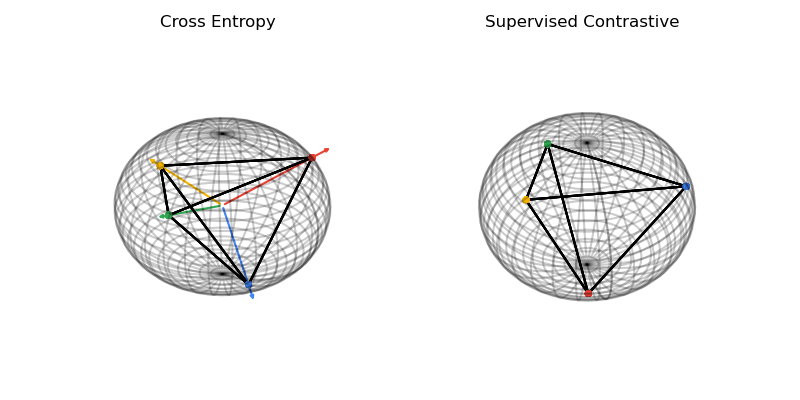

In [182]:
f = compare_ce_sc(ps, ws,ps_sc, 
               labels)

